# ECE 590, Fall 2019 
## Problem Set 6


## Full name: Ana Belen Barcenas J.

## Problem 1: Bayesian Network

**1)**

* False. H and L are not conditionally independent given P because one of the parent nodes (G) is not given.

* True. Since both parent/descendant nodes are given.

* True. G is the only node connecting both P and D. If G is given, P and D are conditionally independent.

* False because once L is given, H and D are fixed. Which is to say, given the output, the input is already defined.

**2) Factorized form:**

**P** (H,D,P,G,L) = **P** (H) **P** (D) **P** (P|H,G) **P** (G|H,D) **P** (L|P,G)



**3)**

**P** (L=1) = P(L=1|P=A, G=A) P(P=A, G=A) + P(L=1|P=A, G=B) P(P=A, G=B) + P(L=1|P=B, G=A) P(P=B, G=A) + P(L=1|P=B, G=B) P(P=B, G=B)

**P** (L=1) = (0.8)(0.4) + (0.6)(0.3) + (0.3)(0.1) + (0.1)(0.2) = 0.55

## Problem 2: Image Denoising using Singular Value Decomposition

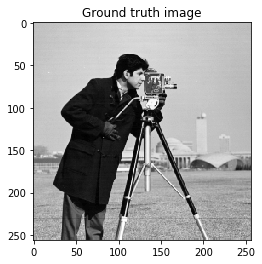

'\nReconstruct the image based on the SVD of the noisy image, then report the PSNR with respect to the ground truth image \n'

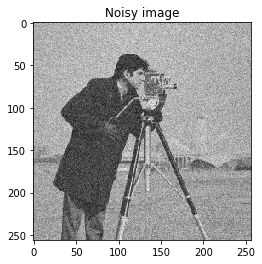

In [4]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

# reading the ground truth image 
im = imageio.imread('cameraman.png')

# normalize the image 
im = (im - np.min(im))/(np.max(im) - np.min(im))

# visualize the image 
plt.imshow(im, cmap="gray")
plt.title("Ground truth image")
plt.show()

# add some noise to the image 
n = 0.1 * np.random.randn(256,256)

# noisy image
im_noisy = im + n

# visualize the image 
plt.imshow(im_noisy, cmap="gray")
plt.title("Noisy image")

"""
Reconstruct the image based on the SVD of the noisy image, then report the PSNR with respect to the ground truth image 
"""


In [67]:
# Program to compute peak signal-to-noise ratio

import math
from sklearn.decomposition import TruncatedSVD

n_component = 100
PSNR_ = []

for i in range(1,n_component+1):
    m = im_noisy.shape[0]
    n = im_noisy.shape[1]
    U, s, V = np.linalg.svd(im_noisy)
    
    S = np.zeros((m, n))
    S[:m, :m] = np.diag(s)
    S = S[:, :i]
    VT = V[:i, :]
    A = U.dot(S.dot(VT))
    
    MSE = (1/(m*n)) * np.sum(np.square(im_noisy-A))

    ratio = (im_noisy.max()**2)/MSE
    PSNR = 10 * math.log(ratio, 10)
    
    PSNR_.append(PSNR)


The best K is K=100


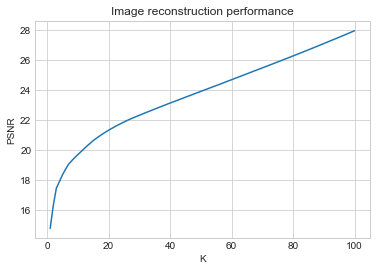

In [77]:
# Let's plot the PSNR vs. K

K = list(range(1,n_component+1))

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

ax = plt.axes()
ax.plot(K,PSNR_)
ax.set(xlabel='K', ylabel='PSNR',
       title='Image reconstruction performance');

print('The best K is K=100')

## Problem 3: Feature extraction using Autoencoder

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Load MNIST dataset:

In [30]:
batch_size = 128
Num_epoch = 10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
Dataset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
DataLoader = torch.utils.data.DataLoader(Datset, batch_size=batch_size, shuffle=True, num_workers=0)
Dataset_test = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
DataLoader_test = torch.utils.data.DataLoader(Datset_test, batch_size=100, shuffle=True, num_workers=0)

if not os.path.exists('./mlp_img'):
    os.mkdir('./mlp_img')


### 1) AE-based feature extraction

In [44]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.enc1 = nn.Linear(784, 128)
        self.enc2 = nn.Linear(128, 64)
        self.enc3 = nn.Linear(64, 12)
        self.enc4 = nn.Linear(12, 3)
        self.dc1 = nn.Linear(3,12)
        self.dc2 = nn.Linear(12,64)
        self.dc3 = nn.Linear(64,128)
        self.dc4 = nn.Linear(128,784)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        self.encoded_x = x
        x = (self.dc1(x))
        x = (self.dc2(x))
        x = (self.dc3(x))
        x = F.tanh(self.dc4(x))
        return self.encoded_x, x
    def extract_features(self,x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        return x

In [45]:
AE = AE()
AE = model.to(device)
criterion  = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-3, weight_decay= 1e-4)


Train Autoencoder:

In [46]:
min_loss = 10e+10
for epoch in range(Num_epoch):
    if epoch == Num_epoch-1: AE_efs = []
    running_loss = 0 
    for batch_ind, (image,_) in enumerate(DataLoader):
        image = image.view(image.size(0), -1).to(device)
        optimizer.zero_grad()
        ef,output = AE(image)
        # If last iteration, return extracted features
        if epoch == Num_epoch-1: AE_efs.append(ef)
        loss = criterion(image, output)
        loss.backward()
        pass
    optimizer.step()
    running_loss += loss.item()
    print('Epoch {}: Loss: {:.4f}'.format(epoch, running_loss/(batch_ind+1)))

/Users/anabelen/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0: Loss: 0.0006
Epoch 1: Loss: 0.0006
Epoch 2: Loss: 0.0006
Epoch 3: Loss: 0.0006
Epoch 4: Loss: 0.0006
Epoch 5: Loss: 0.0006
Epoch 6: Loss: 0.0006
Epoch 7: Loss: 0.0006
Epoch 8: Loss: 0.0006
Epoch 9: Loss: 0.0006


### 2) CAE-based feature extraction

Train Contractive Autoencoder:

In [47]:
Num_epoch = 10
CAE = Autoencoder()
CAE = CAE.to(device)

criterion  = nn.MSELoss()
optimizer = optim.Adam(CAE.parameters(), lr= 1e-3, weight_decay= 1e-4)

In [48]:
def contractive_lf(W, x, r_x, h, lam):
    mse = nn.MSELoss()
    mse_ = mse(r_x, x)
    h_ = h
    sum_ = torch.sum(Variable(W)**2, dim=1)
    sum_ = sum_.unsqueeze(1)
    contractive_loss = torch.sum(torch.mm(h_**2, sum_), 0)
    return mse_ + contractive_loss.mul_(lam)

In [49]:
min_loss = 10e+10
for epoch in range(Num_epoch):
    if epoch == Num_epoch-1: CAE_efs = []
    running_loss = 0 
    for batch_ind, (image,_) in enumerate(DataLoader):
        image = image.view(image.size(0), -1).to(device)
        optimizer.zero_grad()
        ef,output = CAE(image)
        # If last iteration, return extracted features
        if epoch == Num_epoch-1: CAE_efs.append(ef)
        W = model.state_dict()['enc4.weight']
        loss = contractive_lf(W, image, output, ef, 1e-3)
        loss.backward()
        pass
    optimizer.step()
    running_loss += loss.item()
    print('Epoch {}: Loss: {:.4f}'.format(epoch, running_loss/(batch_ind+1)))

/Users/anabelen/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1339: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0: Loss: 0.0020
Epoch 1: Loss: 0.0019
Epoch 2: Loss: 0.0019
Epoch 3: Loss: 0.0018
Epoch 4: Loss: 0.0017
Epoch 5: Loss: 0.0016
Epoch 6: Loss: 0.0016
Epoch 7: Loss: 0.0015
Epoch 8: Loss: 0.0014
Epoch 9: Loss: 0.0013


### 3) PCA-based feature extraction

In [50]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

X_train, y_train = flatten_items(np.array(Dataset.data)) ,(Dataset.targets).to(device)
X_test, y_test = flatten_items(np.array(Dataset_test.data)) ,(Dataset_test.targets).to(device)

pca = PCA(n_components=3)
pca.fit(X_train)
pca_train_ = pca.transform(X_train)
pca_test_ = pca.transform(X_test)